## MT3DMS Problem 1

The purpose of this script is to (1) recreate the example problems that were first
described in the 1999 MT3DMS report, and (2) compare MODFLOW 6-GWT solutions to the
established MT3DMS solutions.

Ten example problems appear in the 1999 MT3DMS manual, starting on page 130.
This notebook demonstrates example 1 from the list below:

  1.  *One-Dimensional Transport in a Uniform Flow Field*,
  2.  One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption,
  3.  Two-Dimensional Transport in a Uniform Flow Field,
  4.  Two-Dimensional Transport in a Diagonal Flow Field,
  5.  Two-Dimensional Transport in a Radial Flow Field,
  6.  Concentration at an Injection/Extraction Well,
  7.  Three-Dimensional Transport in a Uniform Flow Field,
  8.  Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer,
  9.  Two-Dimensional Application Example, and
  10. Three-Dimensional Field Case Study.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Set scenario parameters (make sure there is at least one blank line before next item)
# This entire dictionary is passed to _build_models()_ using the kwargs argument
parameters = {
    "ex-gwt-mt3dms-p01a": {
        "dispersivity": 0.0,
        "retardation": 1.0,
        "decay": 0.0,
    },
    "ex-gwt-mt3dms-p01b": {
        "dispersivity": 10.0,
        "retardation": 1.0,
        "decay": 0.0,
    },
    "ex-gwt-mt3dms-p01c": {
        "dispersivity": 10.0,
        "retardation": 5.0,
        "decay": 0.0,
    },
    "ex-gwt-mt3dms-p01d": {
        "dispersivity": 10.0,
        "retardation": 5.0,
        "decay": 0.002,
    },
}

# Scenario parameter units
#
# add parameter_units to add units to the scenario parameter table that is automatically
# built and used by the .tex input
parameter_units = {
    "dispersivity": "$m$",
    "retardation": "unitless",
    "decay": "$d^{-1}$",
}

# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
ncol = 101  # Number of columns
nrow = 1  # Number of rows
delr = 10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 0.0  # Top of the model ($m$)
botm = -1.0  # Layer bottom elevations ($m$)
prsity = 0.25  # Porosity
perlen = 2000  # Simulation time ($days$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)

# Set some static model parameter values
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
laytyp = 1
nstp = 100.0
dt0 = perlen / nstp
Lx = (ncol - 1) * delr
v = 0.24
q = v * prsity
h1 = q * Lx
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, 0, 0] = h1  # Starting head ($m$)
l = 1000.0  # Needed for plots
icelltype = 1  # Cell conversion type
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[0, 0, 0] = -1
ibound[0, 0, -1] = -1

# Set some static transport related model parameter values
mixelm = 0  # TVD
rhob = 0.25
sp2 = 0.0  # red, but not used in this problem
sconc = np.zeros((nlay, nrow, ncol), dtype=float)
dmcoef = 0.0  # Molecular diffusion coefficient

# Set solver parameter values (and related)
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
ttsmult = 1.0
dceps = 1.0e-5  # HMOC parameters in case they are invoked
nplane = 1  # HMOC
npl = 0  # HMOC
nph = 4  # HMOC
npmin = 0  # HMOC
npmax = 8  # HMOC
nlsink = nplane  # HMOC
npsink = nph  # HMOC

# Time discretization
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

# Create MODFLOW 6 GWT MT3DMS Example 1 Boundary Conditions
# Constant head cells are specified on both ends of the model
chdspd = [[(0, 0, 0), h1], [(0, 0, ncol - 1), 0.0]]
c0 = 1.0
cncspd = [[(0, 0, 0), c0]]

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(
    sim_name,
    dispersivity=0.0,
    retardation=0.0,
    decay=0.0,
    mixelm=0,
    silent=False,
):
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "p01-mf"

    # Instantiate the MODFLOW model
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005"
    )

    # Instantiate discretization package
    # units: itmuni=4 (days), lenuni=2 (m)
    flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        nstp=nstp,
        botm=botm,
        perlen=perlen,
        itmuni=4,
        lenuni=2,
    )

    # Instantiate basic package
    flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

    # Instantiate layer property flow package
    flopy.modflow.ModflowLpf(mf, hk=k11, laytyp=laytyp)

    # Instantiate solver package
    flopy.modflow.ModflowPcg(mf)

    # Instantiate link mass transport package (for writing linker file)
    flopy.modflow.ModflowLmt(mf)

    # Transport
    modelname_mt = "p01-mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=mt3d_ws,
        exe_name="mt3dms",
        modflowmodel=mf,
    )

    c0 = 1.0
    icbund = np.ones((nlay, nrow, ncol), dtype=int)
    icbund[0, 0, 0] = -1
    sconc = np.zeros((nlay, nrow, ncol), dtype=float)
    sconc[0, 0, 0] = c0
    flopy.mt3d.Mt3dBtn(
        mt,
        laycon=laytyp,
        icbund=icbund,
        prsity=prsity,
        sconc=sconc,
        dt0=dt0,
        ifmtcn=1,
    )

    # Instatiate the advection package
    flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )

    # Instantiate the dispersion package
    flopy.mt3d.Mt3dDsp(mt, al=dispersivity)

    # Set reactive variables and instantiate chemical reaction package
    if retardation == 1.0:
        isothm = 0.0
        rc1 = 0.0
    else:
        isothm = 1
    if decay != 0:
        ireact = 1
        rc1 = decay
    else:
        ireact = 0.0
        rc1 = 0.0
    kd = (retardation - 1.0) * prsity / rhob
    flopy.mt3d.Mt3dRct(
        mt,
        isothm=isothm,
        ireact=ireact,
        igetsc=0,
        rhob=rhob,
        sp1=kd,
        rc1=rc1,
        rc2=rc1,
    )

    # Instantiate the source/sink mixing package
    flopy.mt3d.Mt3dSsm(mt)

    # Instantiate the GCG solver in MT3DMS
    flopy.mt3d.Mt3dGcg(mt, mxiter=10)

    # MODFLOW 6
    name = "p01-mf6"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbc",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 groundwater transport package
    gwtname = "gwt-" + name
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=1,
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm == 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    if dispersivity != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=dispersivity,
            ath1=dispersivity,
            filename=f"{gwtname}.dsp",
        )

    # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
    if retardation != 1.0:
        sorption = "linear"
        bulk_density = rhob
        kd = (retardation - 1.0) * prsity / rhob  # prsity & rhob defined in
    else:  # global variable section
        sorption = None
        bulk_density = None
        kd = None
    if decay != 0.0:
        first_order_decay = True
        decay_arg = decay
    else:
        first_order_decay = False
        decay_arg = None
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        sorption=sorption,
        bulk_density=bulk_density,
        distcoef=kd,
        first_order_decay=first_order_decay,
        decay=decay_arg,
        decay_sorbed=decay_arg,
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport constant concentration package
    flopy.mf6.ModflowGwtcnc(
        gwt,
        maxbound=len(cncspd),
        stress_period_data=cncspd,
        save_flows=False,
        pname="CNC-1",
        filename=f"{gwtname}.cnc",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    flopy.mf6.ModflowGwtssm(gwt, sources=[[]], filename=f"{gwtname}.ssm")

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename=f"{name}.gwfgwt",
    )
    return mf, mt, sim


def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()
    mt3d.write_input()
    sim.write_simulation(silent=silent)


@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    """Run models and assert successful completion."""
    success, buff = mf2k5.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = mt3d.run_model(
        silent=silent, report=True, normal_msg="Program completed"
    )
    assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5, 3.5)


def plot_results(mt3d, mf6, idx, ax=None):
    mt3d_out_path = mt3d.model_ws
    mf6.simulation_data.mfpath.get_sim_path()

    # Get the MT3DMS concentration output
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN")
    ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)
    conc_mt3d = ucnobj_mt3d.get_alldata()

    # Get the MF6 concentration output
    gwt = mf6.get_model(list(mf6.model_names)[1])
    ucnobj_mf6 = gwt.output.concentration()
    conc_mf6 = ucnobj_mf6.get_alldata()

    # Create figure for scenario
    with styles.USGSPlot() as fs:
        sim_name = mf6.name
        if ax is None:
            fig, ax = plt.subplots(
                1, 1, figsize=figure_size, dpi=300, tight_layout=True
            )

        ax.plot(
            np.linspace(0, l, ncol),
            conc_mt3d[0, 0, 0, :],
            color="k",
            label="MT3DMS",
            linewidth=0.5,
        )
        ax.plot(
            np.linspace(0, l, ncol),
            conc_mf6[0, 0, 0, :],
            "^",
            markeredgewidth=0.5,
            color="blue",
            fillstyle="none",
            label="MF6",
            markersize=3,
        )
        ax.set_ylim(0, 1.2)
        ax.set_xlim(0, 1000)
        ax.set_xlabel("Distance, in m")
        ax.set_ylabel("Concentration")
        title = "Concentration Profile at Time = 2,000 " + "{}".format(time_units)
        ax.legend()
        letter = chr(ord("@") + idx + 1)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    mf2k5, mt3d, sim = build_models(key, **parameter_dict)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
    if plot:
        plot_results(mt3d, sim, idx)

Run advection only scenario.

run_models took 178.65 ms


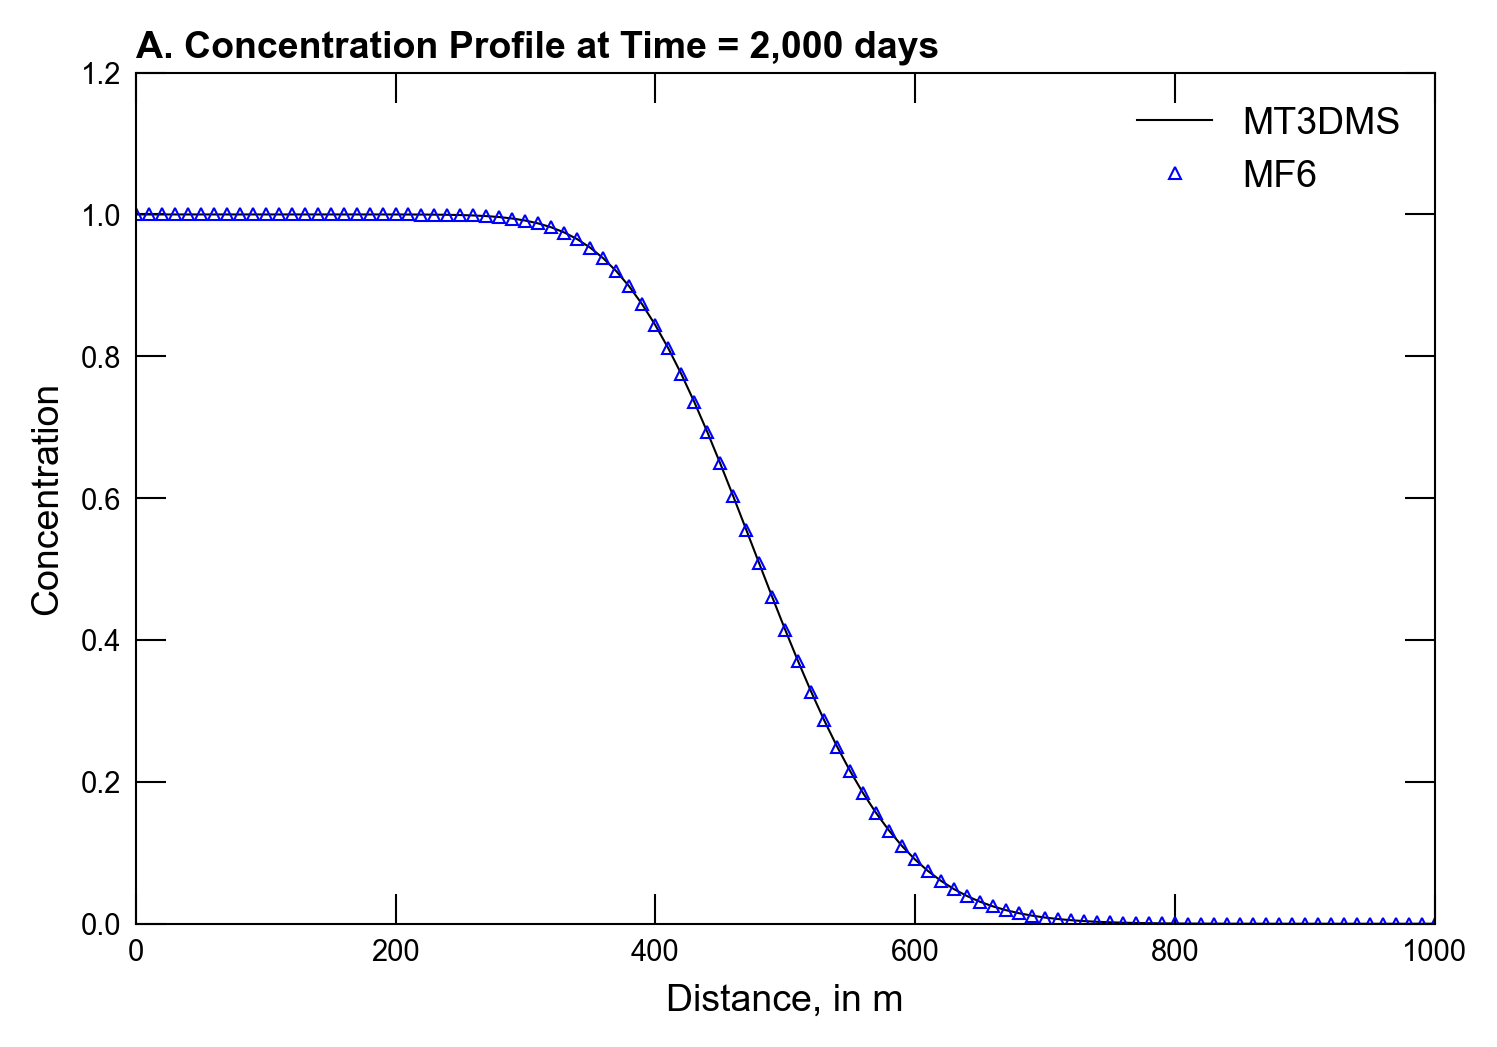

In [6]:
scenario(0)

Run advection and dispersion scenario.

run_models took 198.61 ms


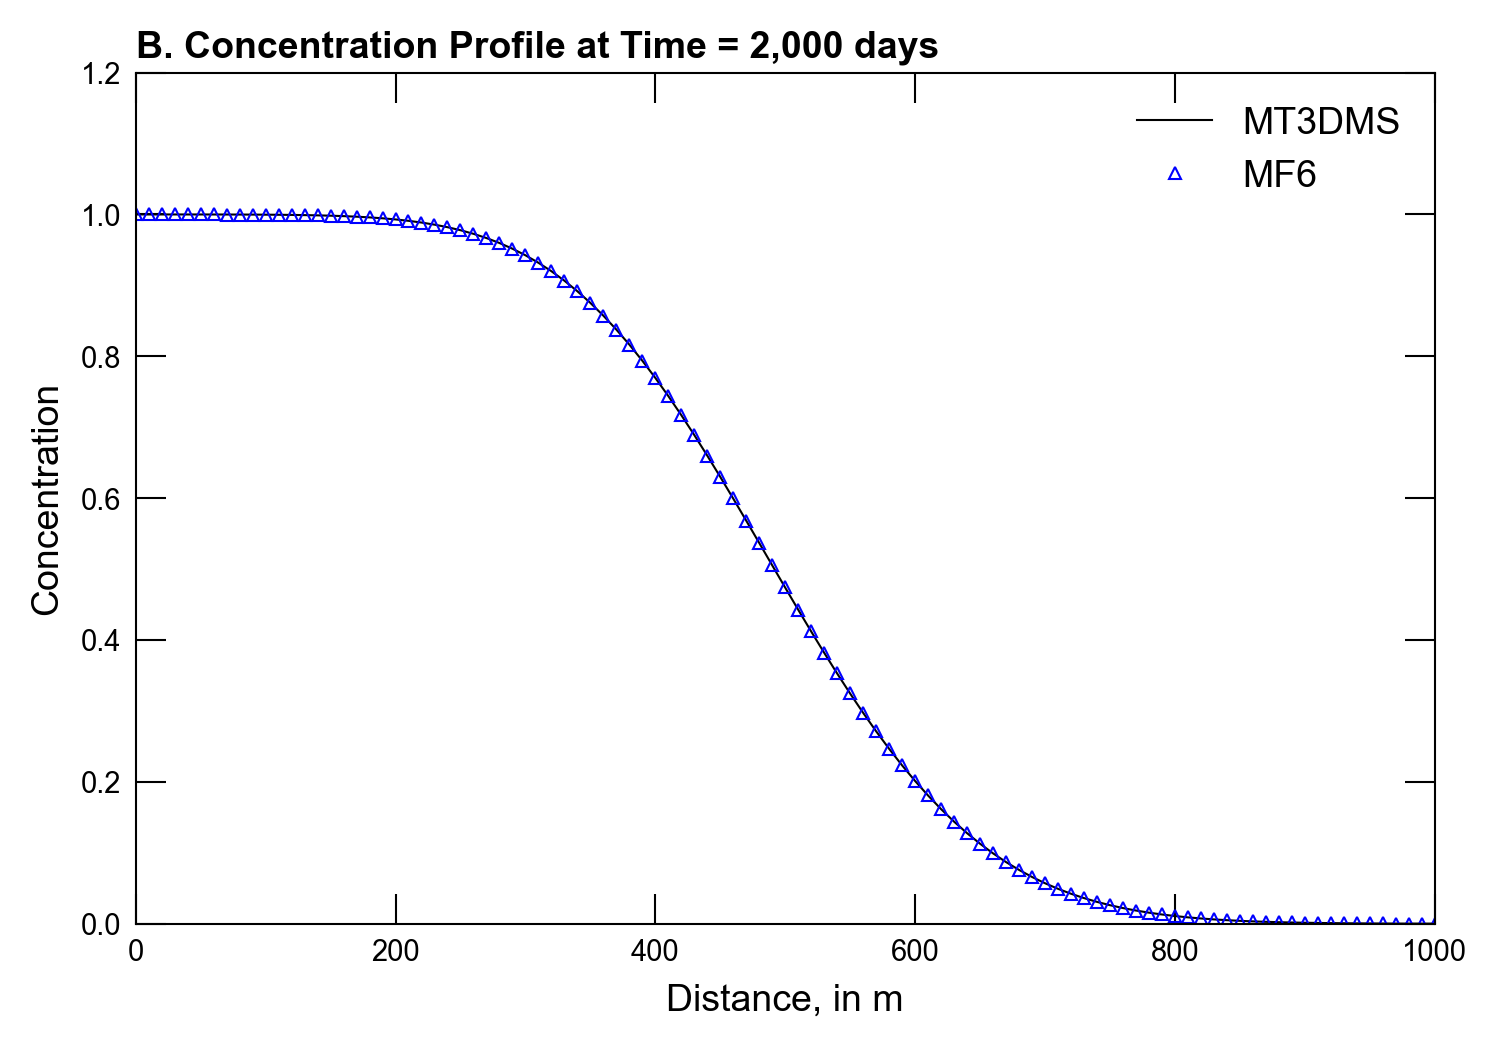

In [7]:
scenario(1)

Run advection, dispersion, and retardation scenario.

run_models took 172.74 ms


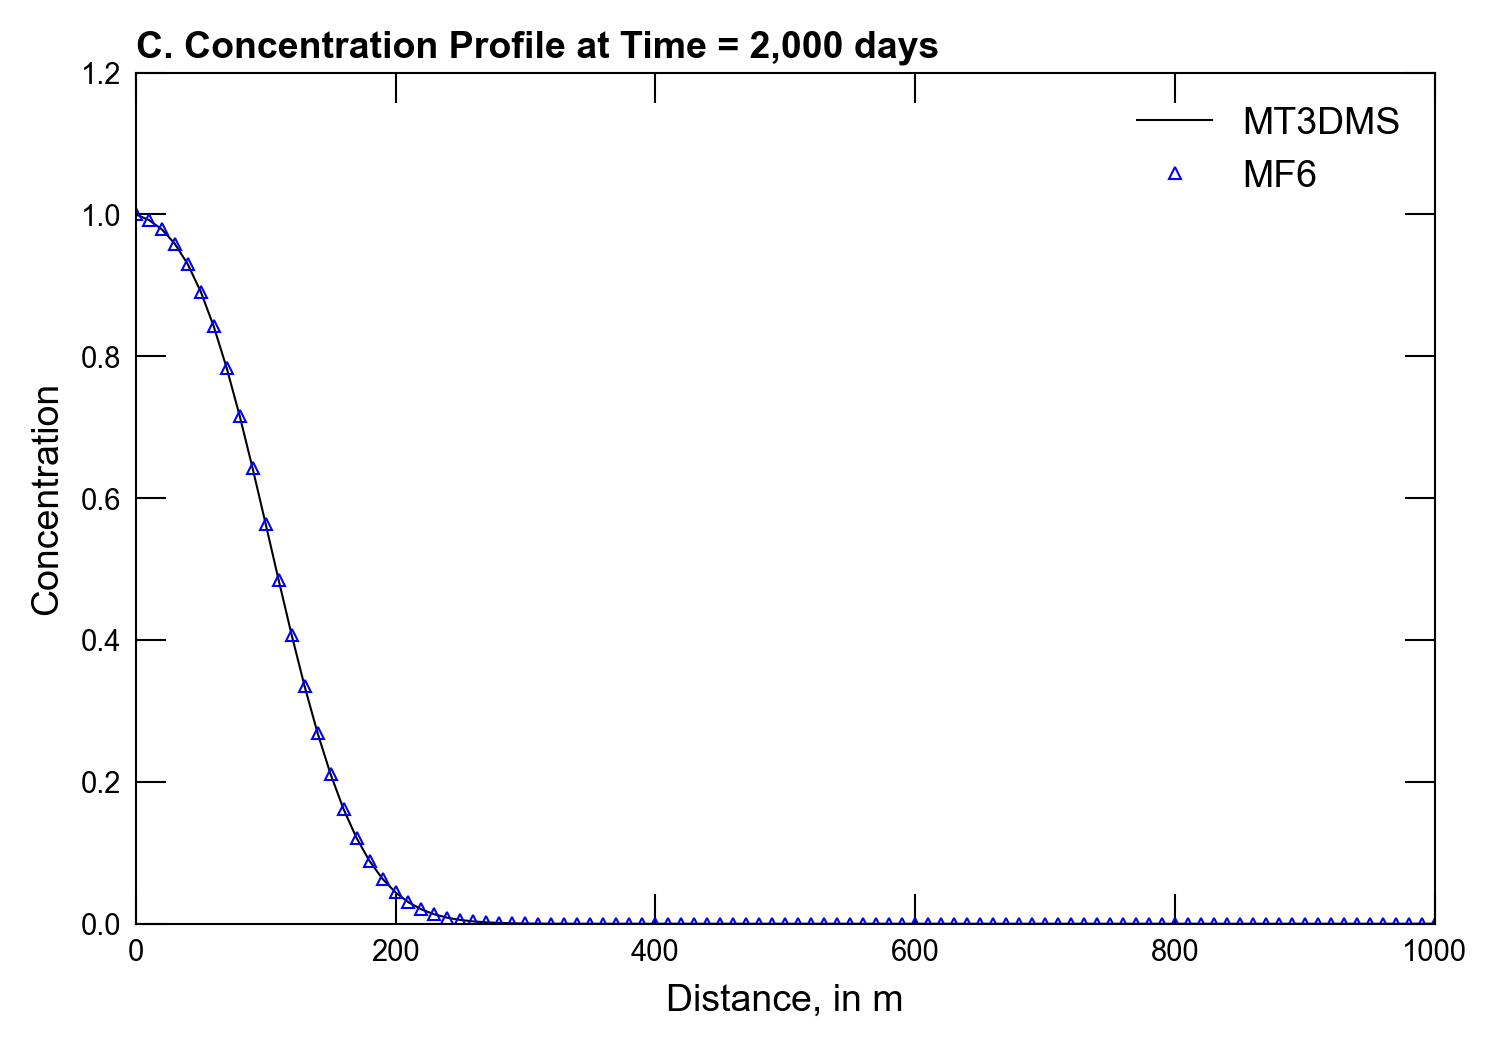

In [8]:
scenario(2)

Run advection, dispersion, retardation, and decay scenario.

run_models took 170.31 ms


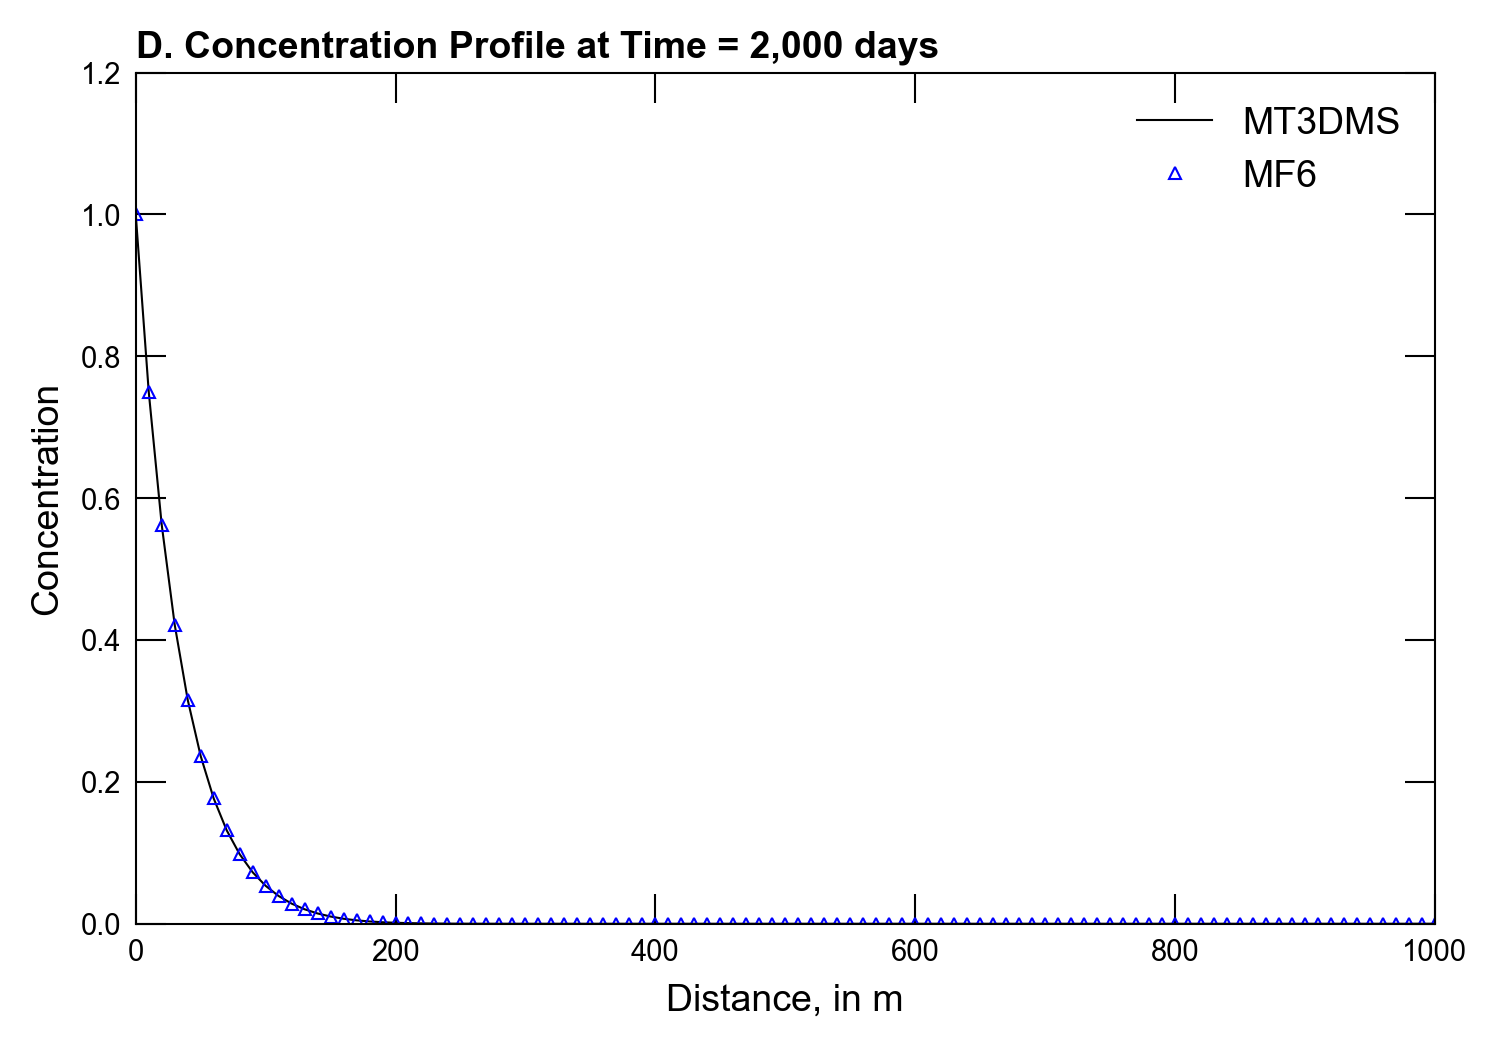

In [9]:
scenario(3)